In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
# context_size = 5, 10, 30
context_size = 5
target_size = 50

In [4]:
def get_sine(sine_params, X, i):
    torch.manual_seed(0)
    return sine_params[i][0] * torch.sin(X + sine_params[i][1]) + torch.randn(X.shape) * 0.1

# Dataset creation

In [5]:
torch.manual_seed(0)
num_datasets = 10
num_points_per_dataset = 100

A = torch.distributions.Uniform(0.5, 5).sample((num_datasets,))
phi = torch.distributions.Uniform(0, 2 * np.pi).sample((num_datasets,))
sine_params = torch.stack((A, phi), dim=1)

# Generate synthetic data for regression
torch.manual_seed(0)
dataset = [None] * num_datasets  # List of datasets for each function

for i in range(num_datasets):
    # upper_bound = 2 * torch.pi / sine_params[i][1]
    upper_bound = 2 * torch.pi
    X = torch.linspace(0, upper_bound, num_points_per_dataset)
    y = get_sine(sine_params, X, i)  # Sine function with noise
    X_y = torch.cat((X.unsqueeze(1), y.unsqueeze(1)), 1)
    dataset[i] = X_y

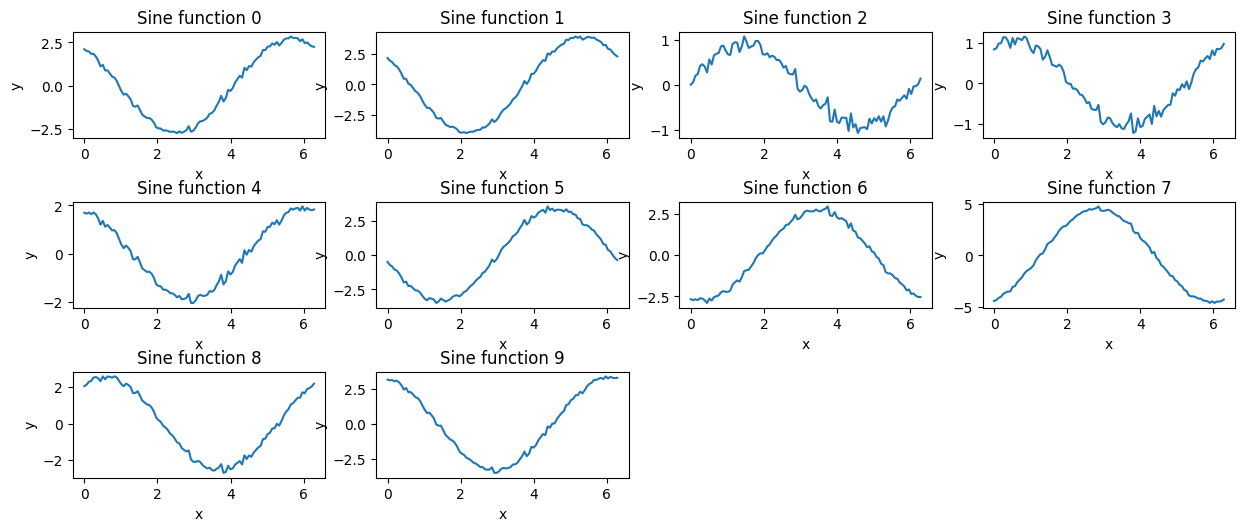

In [6]:
# plot 15 sine functions and adjust margins
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.6)

for i in range(10):
    plt.subplot(4, 4, i+1)
    plt.plot(dataset[i][:, 0].cpu(), dataset[i][:, 1].cpu())
    plt.title('Sine function {}'.format(i))
    plt.xlabel('x')
    plt.ylabel('y')

In [7]:
print('len(dataset): ', len(dataset))
print('len(dataset[0]): ', len(dataset[0]))
print('dataset[0].type(): ', dataset[0].type())

len(dataset):  10
len(dataset[0]):  100
dataset[0].type():  torch.FloatTensor


# Dataset creation for meta learning

In [8]:
# dividing the main dataset into small parts to make it suitable for meta learning

newdataset = []
num_datapoints_per_small_task = 50      # this is the number of datapoints we will use for each iteration of meta learning

for i in range(0, len(dataset)):
    torch.manual_seed(i)
    num_elements = dataset[i].shape[0]
    permuted_indices = torch.randperm(num_elements) # Generate a random permutation of indices
    dataset[i] = dataset[i][permuted_indices]
newdataset = dataset
test_dataset = dataset

In [9]:
print('len(newdataset): ', len(newdataset))
print('len(newdataset[0]): ', len(newdataset[0]))

len(newdataset):  10
len(newdataset[0]):  100


# Testing the model
Replace the following line for with your model path
```python
predictions = adaptiveMLPRegModel(x_context_test, y_context_test, target_x_test, adaptiveNetwork)
```

In [ ]:
predictions_y = []
input_x = []
value_y = []
# Make predictions
with torch.no_grad():
    for test_task in test_dataset:
        context_test = test_task[:context_size]
        target_x_test = test_task[context_size:context_size+target_size, 0].unsqueeze(1)
        target_y_test = test_task[context_size:context_size+target_size, 1].unsqueeze(1)
        x_context_test = context_test[:, 0].unsqueeze(1)
        y_context_test = context_test[:, 1].unsqueeze(1)
        predictions = adaptiveMLPRegModel(x_context_test, y_context_test, target_x_test, adaptiveNetwork)
        input_x.append(target_x_test)
        value_y.append(target_y_test)
        predictions_y.append(predictions)

In [ ]:
plt.figure(figsize=(10, 15))
plt.subplots_adjust(hspace=0.7)

images = [1, 2, 3, 6]

for i in range(len(images)):
    plt.subplot(8,1, i+1)
    plt.scatter(input_x[images[i]].cpu(), value_y[images[i]].cpu(), marker='o', label='Ground Truth')
    plt.scatter(input_x[images[i]].cpu(), predictions_y[images[i]].cpu(), marker='x', label='Predictions')
    plt.xlabel('x')
    plt.ylabel('Prediction')
    plt.title('Function $y = A*sin(x + phi)$'.format(i))
    plt.legend()

# save the plot
plt.savefig(f'./context_comparison_images/{context_size}.png')